In [1]:
import config
print("Using:", config.__file__)
print(open(config.__file__, "r").read())


Using: /home/g202417400/Msproject/FEW_shot/Weakly/config.py
# config.py
import random
from pathlib import Path
import numpy as np
import torch

# ---- Repro / device ----
SEED = 1337

def set_seed(seed: int = SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # reproducible training (slower sometimes)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Paths ----
ROOT_DIR = Path("/home/g202417400/lidc-kaggle/kaggle/archive/LIDC-IDRI-slices")
OUT_DIR  = Path("/home/g202417400/Msproject/MSPO-Net/semisup_runs_dw")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---- Training knobs ----
BATCH_SIZE   = 16
LR           = 1e-5
MAX_EPOCHS   = 100
PATIENCE     = 10
VAL_FRAC_T   = 0.10
VAL_FRAC_S   = 0.10
SPLIT_5_3_2  = (5, 3, 2)
NUM_WORKERS  = 4
IMAGE_SIZE   = (256, 256)   # (H, W) or None





/home/g202417400/.conda/envs/mspo311/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
import importlib, config
importlib.reload(config)

print("Loaded from:", config.__file__)
print("ROOT_DIR:", config.ROOT_DIR)


Loaded from: /home/g202417400/Msproject/FEW_shot/Weakly/config.py
ROOT_DIR: /home/g202417400/lidc-kaggle/kaggle/archive/LIDC-IDRI-slices


In [3]:
import os, sys
print("cwd:", os.getcwd())
print(sys.path[:3])


cwd: /home/g202417400/Msproject/FEW_shot/Weakly
['/home/g202417400/.conda/envs/mspo311/lib/python311.zip', '/home/g202417400/.conda/envs/mspo311/lib/python3.11', '/home/g202417400/.conda/envs/mspo311/lib/python3.11/lib-dynload']


In [4]:
import os
os.chdir("/home/g202417400/Msproject/FEW_shot")


In [5]:
import os, sys
print("cwd:", os.getcwd())
print(sys.path[:3])


cwd: /home/g202417400/Msproject/FEW_shot
['/home/g202417400/.conda/envs/mspo311/lib/python311.zip', '/home/g202417400/.conda/envs/mspo311/lib/python3.11', '/home/g202417400/.conda/envs/mspo311/lib/python3.11/lib-dynload']


In [6]:
from Weakly.config import ROOT_DIR, SEED, VAL_FRAC_T, SPLIT_5_3_2


In [7]:
from Weakly.teacher import make_teacher_swin_unet

model = make_teacher_swin_unet()
print(model)
%pip install torchinfo

from torchinfo import summary

summary(model, input_size=(1, 1, 256, 256))



/home/g202417400/.conda/envs/mspo311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SwinUNet(
  (encoder): FeatureListNet(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (layers_0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
        

Layer (type:depth-idx)                             Output Shape              Param #
SwinUNet                                           [1, 1, 256, 256]          --
├─FeatureListNet: 1-1                              [1, 64, 64, 96]           --
│    └─PatchEmbed: 2-1                             [1, 64, 64, 96]           --
│    │    └─Conv2d: 3-1                            [1, 96, 64, 64]           1,632
│    │    └─LayerNorm: 3-2                         [1, 64, 64, 96]           192
│    └─SwinTransformerStage: 2-2                   [1, 64, 64, 96]           --
│    │    └─Identity: 3-3                          [1, 64, 64, 96]           --
│    │    └─Sequential: 3-4                        [1, 64, 64, 96]           224,694
│    └─SwinTransformerStage: 2-3                   [1, 32, 32, 192]          --
│    │    └─PatchMerging: 3-5                      [1, 32, 32, 192]          74,496
│    │    └─Sequential: 3-6                        [1, 32, 32, 192]          891,756
│    └─SwinTransf

Slice Mask Status

In [8]:
from Weakly.config import ROOT_DIR, SEED, VAL_FRAC_T, SPLIT_5_3_2
from Weakly.data import (
    collect_items_with_all_masks, report_mask_coverage,
    split_5_3_2, split_train_val,
    make_teacher_loaders
)

items = collect_items_with_all_masks(ROOT_DIR)
report_mask_coverage(items)

A, B, C = split_5_3_2(items, seed=SEED, split=SPLIT_5_3_2)

A_train, A_val = split_train_val(A, VAL_FRAC_T)
dlT_tr, dlT_va = make_teacher_loaders(A_train, A_val)


Slice mask status:
  no_mask_files     : 0
  all_empty_masks   : 62
  has_annotations   : 15486
Total slices: 15548
Mask-files-per-slice distribution: {4: 15548}


50 percent Concensus mask

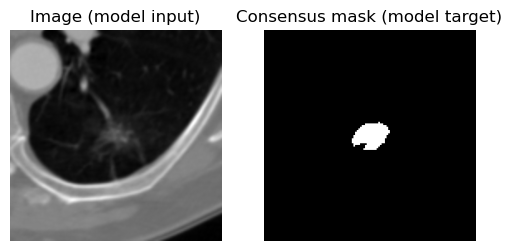

In [9]:
from Weakly.data import LabeledConsensusPNGDataset
from Weakly.config import ROOT_DIR

items = collect_items_with_all_masks(ROOT_DIR)

ds = LabeledConsensusPNGDataset(
    items,
    use_coarse=False,   # or True
    drop_empty=True
)

x, y = ds[0]   # THIS is exactly what training uses

img = x.squeeze().numpy()
msk = y.squeeze().numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Image (model input)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(msk, cmap="gray")
plt.title("Consensus mask (model target)")
plt.axis("off")

plt.show()


Mask status

In [10]:
from Weakly.data import classify_slice_masks

no_mask = 0
all_empty = 0
has_ann = 0

for ip, mask_paths in items:
    cls = classify_slice_masks(mask_paths)
    if cls == "no_mask_files":
        no_mask += 1
    elif cls == "all_empty_masks":
        all_empty += 1
    else:
        has_ann += 1

print("Original slices:", len(items))
print("Has annotations:", has_ann)
print("No mask files:", no_mask)
print("All masks empty:", all_empty)
print("Dropped total:", no_mask + all_empty)
print("Kept in dataset:", len(ds))


Original slices: 15548
Has annotations: 15486
No mask files: 0
All masks empty: 62
Dropped total: 62
Kept in dataset: 15486


Data Split : Teacher : 50% , Student : 30% and Test : 20 percent(fine label)

In [11]:
import importlib
import Weakly.config as cfg
import Weakly.data as data
importlib.reload(cfg); importlib.reload(data)

from Weakly.config import ROOT_DIR, OUT_DIR, DEVICE, SEED, LR, MAX_EPOCHS, PATIENCE, BATCH_SIZE, NUM_WORKERS, VAL_FRAC_T, VAL_FRAC_S, SPLIT_5_3_2
from Weakly.data import collect_items_with_all_masks, split_5_3_2, split_train_val, make_teacher_loaders, UnlabeledPNGDataset, PseudoLabeledDataset
from Weakly.train_utils import train_model, eval_epoch
import torch
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import random

cfg.set_seed(SEED)

# Build items & splits
items = collect_items_with_all_masks(ROOT_DIR)
A, B, C = split_5_3_2(items, seed=SEED, split=SPLIT_5_3_2)

A_train, A_val = split_train_val(A, VAL_FRAC_T)
dlT_tr, dlT_va = make_teacher_loaders(A_train, A_val)

# Test loader (fine/consensus, not coarse)
from Weakly.data import LabeledConsensusPNGDataset
dl_test = DataLoader(
    LabeledConsensusPNGDataset(C, use_coarse=False, drop_empty=True),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
)

# Unlabeled student pool B
xs_paths = [ip for (ip, _) in B]
dlXs = DataLoader(
    UnlabeledPNGDataset(xs_paths),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
)

print("Teacher train/val:", len(dlT_tr.dataset), len(dlT_va.dataset))
print("Student unlabeled:", len(dlXs.dataset))
print("Test:", len(dl_test.dataset))


Teacher train/val: 6971 777
Student unlabeled: 4664
Test: 3095


In [1]:
import torch
print(torch.__version__)       # PyTorch version
print(torch.version.cuda)      # CUDA version PyTorch was built with
print(torch.cuda.is_available())


2.5.1+cu121
12.1
False


/home/g202417400/.conda/envs/mspo311/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
!pip3 install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio==0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip3 install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip3 install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip3 install torch-cluster -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip3 install torch-geometric

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.10.1+cu113 (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0, 2.9.0, 2.9.1, 2.10.0)
ERROR: No matching distribution found for torch==1.10.1+cu113
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'torch-scatter' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'torch-scatter'. Discussion can be found at https://github.com/pypa/pip/issues/6334
ERROR: Operation cance

GPU Selection

In [12]:
import torch
print(torch.cuda.device_count())   # → 1
print(torch.cuda.get_device_name(0))  # → RTX 3090

import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU count:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}:", torch.cuda.get_device_name(i))
        props = torch.cuda.get_device_properties(i)
        print(f"  VRAM (GB): {props.total_memory / 1024**3:.2f}")
        print(f"  Compute capability: {props.major}.{props.minor}")
else:
    print("No CUDA GPU detected by PyTorch.")


0


/home/g202417400/.conda/envs/mspo311/lib/python3.11/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


RuntimeError: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW

In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch, gc
gc.collect()
torch.cuda.empty_cache()

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Visible GPUs:", torch.cuda.device_count())
print("Device:", DEVICE)
print("Name:", torch.cuda.get_device_name(0))

teacher = make_teacher_swin_unet(in_ch=1, out_ch=1, img_size=256).to(DEVICE)
print("Teacher device:", next(teacher.parameters()).device)


Visible GPUs: 0
Device: cpu


RuntimeError: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW

In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [14]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)          # should print: cuda
print(torch.cuda.current_device())  # should print: 0 (mapped to physical GPU 3)


cuda
0


In [15]:
import torch

torch.cuda.set_device(0)
device = torch.device("cuda:0")

print(torch.cuda.get_device_name(device))


NVIDIA GeForce RTX 3090


In [16]:
# --- Cell 2 ---
import torch
from Weakly.models.attentionunet import make_teacher_swin_unet
from Weakly.train_utils import train_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("GPU name:", torch.cuda.get_device_name(0))


Using device: cuda
GPU name: NVIDIA GeForce RTX 3090


In [16]:
import sys
!{sys.executable} -m pip install timm

import timm
print("timm version:", timm.__version__)


timm version: 1.0.22


/home/g202417400/.conda/envs/mspo311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# --- Cell 3 ---
#pip install timm
model = make_teacher_swin_unet(
    in_ch=1,
    out_ch=1,
    img_size=256
).to(device)


Import train model

In [18]:
import csv
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from Weakly.config import (
    set_seed, SEED, ROOT_DIR, OUT_DIR,
    BATCH_SIZE, LR, MAX_EPOCHS, PATIENCE, NUM_WORKERS
)
from Weakly.data import (
    build_splits_and_teacher_loaders,
    UnlabeledPNGDataset,
    PseudoLabeledDataset,
)
from Weakly.models.attentionunet import make_teacher_swin_unet
from Weakly.models.dwUnet import make_student_dwunet
from Weakly.train_utils import (
    train_model,
    bce_dice_loss,
    compute_metrics_from_logits,
)


In [19]:
import csv
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from Weakly.config import (
    set_seed, SEED, ROOT_DIR, OUT_DIR,
    BATCH_SIZE, LR, MAX_EPOCHS, PATIENCE, NUM_WORKERS
)
from Weakly.data import (
    build_splits_and_teacher_loaders,
    UnlabeledPNGDataset,
    PseudoLabeledDataset,
)
from Weakly.models.attentionunet import make_teacher_swin_unet
from Weakly.models.dwUnet import make_student_dwunet
from Weakly.train_utils import (
    train_model,
    bce_dice_loss,
    compute_metrics_from_logits,
)


In [20]:
from Weakly.config import (
    set_seed, SEED, ROOT_DIR, OUT_DIR,
    BATCH_SIZE, LR, MAX_EPOCHS, PATIENCE, NUM_WORKERS
)

print("SEED        :", SEED)
print("ROOT_DIR    :", ROOT_DIR)
print("OUT_DIR     :", OUT_DIR)
print("BATCH_SIZE  :", BATCH_SIZE)
print("LR          :", LR)
print("MAX_EPOCHS  :", MAX_EPOCHS)
print("PATIENCE    :", PATIENCE)
print("NUM_WORKERS :", NUM_WORKERS)


SEED        : 1337
ROOT_DIR    : /home/g202417400/lidc-kaggle/kaggle/archive/LIDC-IDRI-slices
OUT_DIR     : /home/g202417400/Msproject/MSPO-Net/semisup_runs_dw
BATCH_SIZE  : 16
LR          : 1e-05
MAX_EPOCHS  : 100
PATIENCE    : 10
NUM_WORKERS : 4


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, torch.cuda.get_device_name(0))


cuda NVIDIA GeForce RTX 3090


In [21]:
def save_history_csv(history, path: Path):
    if not history:
        return
    with open(path, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=history[0].keys())
        w.writeheader()
        w.writerows(history)


def plot_history_2x2(history, out_png: Path, title=""):
    epochs = [h["epoch"] for h in history]

    plt.figure(figsize=(12, 8))

    plt.subplot(2,2,1)
    plt.plot(epochs, [h["train_loss"] for h in history], label="train")
    plt.plot(epochs, [h["val_loss"] for h in history], label="val")
    plt.title("Loss"); plt.legend()

    plt.subplot(2,2,2)
    plt.plot(epochs, [h["train_dice"] for h in history], label="train")
    plt.plot(epochs, [h["val_dice"] for h in history], label="val")
    plt.title("Dice"); plt.legend()

    plt.subplot(2,2,3)
    plt.plot(epochs, [h["train_iou"] for h in history], label="train")
    plt.plot(epochs, [h["val_iou"] for h in history], label="val")
    plt.title("IoU"); plt.legend()

    plt.subplot(2,2,4)
    plt.plot(epochs, [h["train_acc"] for h in history], label="train")
    plt.plot(epochs, [h["val_acc"] for h in history], label="val")
    plt.title("Pixel Acc"); plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()


def plot_teacher_student_dice(
    teacher_csv: Path,
    student_csv: Path,
    out_png: Path
):
    def read(csv_path):
        ep, tr, va = [], [], []
        with open(csv_path) as f:
            r = csv.DictReader(f)
            for row in r:
                ep.append(int(row["epoch"]))
                tr.append(float(row["train_dice"]))
                va.append(float(row["val_dice"]))
        return ep, tr, va

    t_ep, t_tr, t_va = read(teacher_csv)
    s_ep, s_tr, s_va = read(student_csv)

    plt.figure(figsize=(10,6))
    plt.plot(t_ep, t_tr, label="Teacher train")
    plt.plot(t_ep, t_va, label="Teacher val")
    plt.plot(s_ep, s_tr, label="Student train")
    plt.plot(s_ep, s_va, label="Student val")
    plt.xlabel("Epoch"); plt.ylabel("Dice")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()


New

In [ ]:
def train_student_with_kd(
    student, teacher, train_loader, val_loader, device, out_dir, tag,
    lambda_fd=0.5,  # feature distill weight
    use_logit_kd=False, lambda_kd=1.0
):
    import torch.nn as nn
    import torch.nn.functional as F

    # ---- feature cosine loss ----
    def kd_feature_cosine(student_feat, teacher_feat, eps=1e-6):
        s = student_feat.flatten(2)  # [B, C, HW]
        t = teacher_feat.flatten(2)
        s = F.normalize(s, dim=1, eps=eps)
        t = F.normalize(t, dim=1, eps=eps)
        cos = (s * t).sum(dim=1)     # [B, HW]
        return 1.0 - cos.mean()

    # ---- adapter ----
    class FeatureAdapter(nn.Module):
        def __init__(self, in_c, out_c):
            super().__init__()
            self.proj = nn.Conv2d(in_c, out_c, 1, bias=False)
        def forward(self, x):
            return self.proj(x)

    # Freeze teacher
    teacher.eval()
    for p in teacher.parameters():
        p.requires_grad_(False)

    # Build adapter for: teacher f0 -> student d3
    # We assume you use DWUNet(base=...) and teacher.enc_ch exists (from SwinUNet)
    student_base = getattr(student, "base", None)  # if you stored it; otherwise set manually
    # If student has no attribute, infer from known layer shapes at runtime later.
    # easiest: just compute student d3 channels from model definition: base*4.
    # If you know base=32, just set student_d3_c = 128.
    # Here is a robust way: do a tiny dry-run to get shapes once.
    with torch.no_grad():
        x0, _ = next(iter(train_loader))
        x0 = x0.to(device)
        _, (d1, d2, d3, d4, bt) = student(x0, return_feats=True)
        student_d3_c = d3.shape[1]

    teacher_f0_c = teacher.enc_ch[0]
    adapter_t0 = FeatureAdapter(teacher_f0_c, student_d3_c).to(device)

    # Optimizer should include adapter params too
    opt = torch.optim.Adam(list(student.parameters()) + list(adapter_t0.parameters()), lr=LR)

    history = []
    best = 1e9
    best_state = None

    for epoch in range(1, MAX_EPOCHS + 1):
        student.train()
        adapter_t0.train()

        tl = ta = ti = td = 0.0
        n = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()

            # ---- forward with features ----
            s_logits, (sd1, sd2, sd3, sd4, sbt) = student(x, return_feats=True)

            with torch.no_grad():
                t_logits, (tf0, tf1, tf2, tf3) = teacher(x, return_feats=True)

            # ---- supervised ----
            sup = bce_dice_loss(s_logits, y)

            # ---- feature KD (teacher f0 -> student d3) ----
            tf0p = adapter_t0(tf0)
            if tf0p.shape[-2:] != sd3.shape[-2:]:
                tf0p = F.interpolate(tf0p, size=sd3.shape[-2:], mode="bilinear", align_corners=False)

            fd = kd_feature_cosine(sd3, tf0p)

            # ---- (optional) keep logit KD too ----
            if use_logit_kd:
                kd = kd_pixel_bce(s_logits, t_logits)
                loss = sup + lambda_fd * fd + lambda_kd * kd
            else:
                loss = sup + lambda_fd * fd

            loss.backward()
            opt.step()

            m = compute_metrics_from_logits(s_logits, y)
            bs = x.size(0)
            tl += loss.item() * bs
            ta += m["acc"] * bs
            ti += m["iou"] * bs
            td += m["dice"] * bs
            n += bs

        train = dict(loss=tl / n, acc=ta / n, iou=ti / n, dice=td / n)

        # ---- validation unchanged (no KD) ----
        student.eval()
        adapter_t0.eval()

        vl = va = vi = vd = 0.0
        vn = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                s = student(x)  # normal forward ok
                loss = bce_dice_loss(s, y)
                m = compute_metrics_from_logits(s, y)
                bs = x.size(0)
                vl += loss.item() * bs
                va += m["acc"] * bs
                vi += m["iou"] * bs
                vd += m["dice"] * bs
                vn += bs

        row = {
            "epoch": epoch,
            "train_loss": train["loss"],
            "train_acc": train["acc"],
            "train_iou": train["iou"],
            "train_dice": train["dice"],
            "val_loss": vl / vn,
            "val_acc": va / vn,
            "val_iou": vi / vn,
            "val_dice": vd / vn,
        }
        history.append(row)

        print(f"[student] ep {epoch:03d} | "
              f"tr dice {row['train_dice']:.3f} | "
              f"va dice {row['val_dice']:.3f}")

        if row["val_loss"] < best:
            best = row["val_loss"]
            best_state = {k: v.cpu() for k, v in student.state_dict().items()}

        if epoch > PATIENCE and epoch - min(range(len(history)), key=lambda i: history[i]["val_loss"]) >= PATIENCE:
            break

    student.load_state_dict(best_state)
    save_history_csv(history, out_dir / f"{tag}_history.csv")
    plot_history_2x2(history, out_dir / f"{tag}_curves.png", tag)

    return history


In [23]:

#student -teacher softlabel-temp loss , T=2
def kd_pixel_bce(student_logits, teacher_logits, T=2.0):
    s = torch.sigmoid(student_logits / T)
    t = torch.sigmoid(teacher_logits / T)
    return F.binary_cross_entropy(s, t) * (T * T)


@torch.no_grad()
def make_pseudo_pairs(teacher, image_paths, device):
    teacher.eval()
    ds = UnlabeledPNGDataset(image_paths)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)

    out = []
    for x, paths in dl:
        x = x.to(device)
        probs = torch.sigmoid(teacher(x))
        pmask = (probs > 0.5).byte().cpu().numpy() * 255
        for i, p in enumerate(paths):
            out.append((Path(p), pmask[i, 0]))
    return out


In [24]:
def train_student_with_kd(
    student, teacher, train_loader, val_loader, device, out_dir, tag
):
    opt = torch.optim.Adam(student.parameters(), lr=LR)
    history = []
    best = 1e9
    best_state = None

    for epoch in range(1, MAX_EPOCHS+1):
        student.train()
        tl = ta = ti = td = 0.0
        n = 0

        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()

            s = student(x)
            with torch.no_grad():
                t = teacher(x)

            sup = bce_dice_loss(s,y)
            kd  = kd_pixel_bce(s,t)
            loss = sup + kd
            loss.backward()
            opt.step()

            m = compute_metrics_from_logits(s,y)
            bs = x.size(0)
            tl += loss.item()*bs
            ta += m["acc"]*bs
            ti += m["iou"]*bs
            td += m["dice"]*bs
            n += bs

        train = dict(
            loss=tl/n, acc=ta/n, iou=ti/n, dice=td/n
        )

        student.eval()
        vl = va = vi = vd = 0.0
        vn = 0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                s = student(x)
                loss = bce_dice_loss(s,y)
                m = compute_metrics_from_logits(s,y)
                bs = x.size(0)
                vl += loss.item()*bs
                va += m["acc"]*bs
                vi += m["iou"]*bs
                vd += m["dice"]*bs
                vn += bs

        row = {
            "epoch": epoch,
            "train_loss": train["loss"],
            "train_acc": train["acc"],
            "train_iou": train["iou"],
            "train_dice": train["dice"],
            "val_loss": vl/vn,
            "val_acc": va/vn,
            "val_iou": vi/vn,
            "val_dice": vd/vn,
        }
        history.append(row)

        print(f"[student] ep {epoch:03d} | "
              f"tr dice {row['train_dice']:.3f} | "
              f"va dice {row['val_dice']:.3f}")

        if row["val_loss"] < best:
            best = row["val_loss"]
            best_state = {k:v.cpu() for k,v in student.state_dict().items()}

        if epoch > PATIENCE and epoch - min(range(len(history)), key=lambda i: history[i]["val_loss"]) >= PATIENCE:
            break

    student.load_state_dict(best_state)
    save_history_csv(history, out_dir/f"{tag}_history.csv")
    plot_history_2x2(history, out_dir/f"{tag}_curves.png", tag)

    return history


In [25]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Training teacher

In [ ]:
import importlib
import Weakly.models.attentionunet as T
importlib.reload(T)

m = T.make_teacher_swin_unet().cuda()
x = torch.randn(2, 1, 256, 256).cuda()
y = m(x)
print(y.shape)


torch.Size([2, 1, 256, 256])


In [27]:
set_seed(SEED)

items, splits, tv, loaders, B_imgs = build_splits_and_teacher_loaders(ROOT_DIR)
dlT_tr, dlT_va = loaders

# ---- Teacher ----
teacher = make_teacher_swin_unet().to(device)
#teacher= '/home/g202417400/Msproject/MSPO-Net/semisup_runs_dw/teacher/teacher_att_up_best.pt'
# teacher_out = OUT_DIR / "teacher"
# teacher_tag = "teacher_att_up"

# teacher, _ = train_model(
#     teacher, dlT_tr, dlT_va, device,
#     teacher_out, teacher_tag,
#     LR, MAX_EPOCHS, PATIENCE
# )

# ---- Student ----
pseudo = make_pseudo_pairs(teacher, B_imgs, device)
split = int(0.9*len(pseudo))
tr, va = pseudo[:split], pseudo[split:]

dlS_tr = DataLoader(PseudoLabeledDataset(tr), batch_size=BATCH_SIZE, shuffle=True)
dlS_va = DataLoader(PseudoLabeledDataset(va), batch_size=BATCH_SIZE)

# student = make_student_dwunet().to(device)
# student_out = OUT_DIR / "student_kd"
# student_tag = "dwunetswin_targetKD"

# train_student_with_kd(
#     student, teacher,
#     dlS_tr, dlS_va,
#     device, student_out, student_tag
# )

# # ---- Combined plot ----
# plot_teacher_student_dice(
#     teacher_out/f"{teacher_tag}_history.csv",
#     student_out/f"{student_tag}_history.csv",
#     OUT_DIR/"teacher_vs_student_dice.png"
# )


Slice mask status:
  no_mask_files     : 0
  all_empty_masks   : 62
  has_annotations   : 15486
Total slices: 15548
Mask-files-per-slice distribution: {4: 15548}


In [ ]:
student = make_student_dwunet().to(device)
student_out = OUT_DIR / "student_kd"
student_tag = "dwunetatt_targetKD"
teacher_out = OUT_DIR / "teacher"
teacher_tag = "teacher_att_up"


train_student_with_kd(
    student, teacher,
    dlS_tr, dlS_va,
    device, student_out, student_tag
)

# ---- Combined plot ----
plot_teacher_student_dice(
    teacher_out/f"{teacher_tag}_history.csv",
    student_out/f"{student_tag}_history.csv",
    OUT_DIR/"teacher_vs_student_dice_att.png"
)


[student] ep 001 | tr dice 0.029 | va dice 0.025
[student] ep 002 | tr dice 0.021 | va dice 0.017
[student] ep 003 | tr dice 0.015 | va dice 0.014
[student] ep 004 | tr dice 0.015 | va dice 0.027
[student] ep 005 | tr dice 0.084 | va dice 0.172
[student] ep 006 | tr dice 0.224 | va dice 0.254
[student] ep 007 | tr dice 0.280 | va dice 0.295
[student] ep 008 | tr dice 0.310 | va dice 0.313
[student] ep 009 | tr dice 0.332 | va dice 0.337
[student] ep 010 | tr dice 0.350 | va dice 0.351
[student] ep 011 | tr dice 0.374 | va dice 0.383
[student] ep 012 | tr dice 0.388 | va dice 0.390
[student] ep 013 | tr dice 0.399 | va dice 0.400
[student] ep 014 | tr dice 0.412 | va dice 0.408
[student] ep 015 | tr dice 0.418 | va dice 0.414
[student] ep 016 | tr dice 0.428 | va dice 0.423
[student] ep 017 | tr dice 0.436 | va dice 0.437
[student] ep 018 | tr dice 0.447 | va dice 0.440
[student] ep 019 | tr dice 0.454 | va dice 0.448
[student] ep 020 | tr dice 0.459 | va dice 0.451
[student] ep 021 | t

In [28]:
teacher = make_teacher_swin_unet().to(device)

ckpt_path = "/home/g202417400/Msproject/MSPO-Net/semisup_runs_dw/teacher/teacher_att_up_best.pt"
ckpt = torch.load(ckpt_path, map_location=device)

# pick the right key
if isinstance(ckpt, dict):
    if "model_state" in ckpt:
        state_dict = ckpt["model_state"]
    elif "state_dict" in ckpt:
        state_dict = ckpt["state_dict"]
    elif "model" in ckpt:
        state_dict = ckpt["model"]
    else:
        # maybe it's already a state_dict with parameter keys
        state_dict = ckpt
else:
    state_dict = ckpt

teacher.load_state_dict(state_dict, strict=True)
teacher.eval()


/tmp/ipykernel_1199219/312059856.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


AttentionUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc0): DoubleConv(
    (block): Sequential(
      (0): ConvBNReLU(
        (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
        (drop): Identity()
      )
      (1): ConvBNReLU(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
        (drop): Identity()
      )
    )
  )
  (enc1): DoubleConv(
    (block): Sequential(
      (0): ConvBNReLU(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplac

In [29]:
teacher = make_teacher_swin_unet().to(device)

ckpt_path = "/home/g202417400/Msproject/MSPO-Net/semisup_runs_dw/teacher/teacher_att_up_best.pt"
ckpt = torch.load(ckpt_path, map_location=device)

# your checkpoint uses this key (based on the error)
teacher.load_state_dict(ckpt["model_state"], strict=True)

teacher.eval()

x = torch.randn(2, 1, 256, 256).to(device)
with torch.no_grad():
    p = torch.sigmoid(teacher(x))
print("teacher prob stats:", p.min().item(), p.max().item(), p.mean().item())



teacher prob stats: 8.345465636953811e-32 1.0 0.14701487123966217


/tmp/ipykernel_1199219/521689975.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


In [30]:
pseudo = make_pseudo_pairs(teacher, B_imgs, device)
split = int(0.9*len(pseudo))
tr, va = pseudo[:split], pseudo[split:]

dlS_tr = DataLoader(PseudoLabeledDataset(tr), batch_size=BATCH_SIZE, shuffle=True)
dlS_va = DataLoader(PseudoLabeledDataset(va), batch_size=BATCH_SIZE)



In [31]:
# teacher_tag = "teacher_att_up"

teacher_out = OUT_DIR / "teacher"
teacher_tag = "teacher_att_up"
student = make_student_dwunet().to(device)
student_out = OUT_DIR / "student_kd"
student_tag = "dwunetatt_targetKD"

train_student_with_kd(
    student, teacher,
    dlS_tr, dlS_va,
    device, student_out, student_tag
)

# ---- Combined plot ----
plot_teacher_student_dice(
    teacher_out/f"{teacher_tag}_history.csv",
    student_out/f"{student_tag}_history.csv",
    OUT_DIR/"teacher_vs_student_dice_att.png"
)


[student] ep 001 | tr dice 0.030 | va dice 0.028
[student] ep 002 | tr dice 0.033 | va dice 0.032
[student] ep 003 | tr dice 0.030 | va dice 0.025
[student] ep 004 | tr dice 0.022 | va dice 0.018
[student] ep 005 | tr dice 0.015 | va dice 0.012
[student] ep 006 | tr dice 0.010 | va dice 0.007
[student] ep 007 | tr dice 0.007 | va dice 0.006
[student] ep 008 | tr dice 0.011 | va dice 0.011
[student] ep 009 | tr dice 0.043 | va dice 0.069
[student] ep 010 | tr dice 0.137 | va dice 0.167
[student] ep 011 | tr dice 0.218 | va dice 0.237
[student] ep 012 | tr dice 0.261 | va dice 0.264
[student] ep 013 | tr dice 0.290 | va dice 0.293
[student] ep 014 | tr dice 0.310 | va dice 0.323
[student] ep 015 | tr dice 0.330 | va dice 0.345
[student] ep 016 | tr dice 0.344 | va dice 0.352
[student] ep 017 | tr dice 0.358 | va dice 0.363
[student] ep 018 | tr dice 0.364 | va dice 0.379
[student] ep 019 | tr dice 0.377 | va dice 0.380
[student] ep 020 | tr dice 0.382 | va dice 0.393
[student] ep 021 | t

AttentionUnet

In [32]:
from Weakly.metrics_profile import (
    evaluate_binary_segmentation,
    estimate_gflops,
    benchmark_inference
)

teacher_metrics = evaluate_binary_segmentation(
    teacher,
    dl_test,          # fine/consensus GT loader
    DEVICE,
    threshold=0.5
)

print("\n=== Teacher Test Metrics ===")

order = ["acc", "precision", "recall", "f1", "iou", "dice", "specificity",
         "hd95_mean", "hd95_std", "hd95_n"]

for k in order:
    v = teacher_metrics.get(k, None)

    if v is None:
        print(f"{k}: N/A")
    elif k == "hd95_n":
        print(f"{k}: {int(v)}")
    else:
        print(f"{k}: {float(v):.4f}")

ms_img, fps = benchmark_inference(
    teacher,
    input_shape=(1, 1, 256, 256),
    device=str(DEVICE)   # <-- THIS fixes it
)

from Weakly.metrics_profile import benchmark_inference

teacher.eval()
ms_img, fps = benchmark_inference(
    teacher,
    input_shape=(1, 1, 256, 256),
    device=str(DEVICE)   # <-- THIS fixes it
)


print(f"Teacher inference: {ms_img:.2f} ms/image | {fps:.1f} FPS")


ms_img, fps = benchmark_inference(
    student,
    input_shape=(1, 1, 256, 256),
    device=str(DEVICE)
)

print(f"student inference: {ms_img:.2f} ms/image | {fps:.1f} FPS")


gflops, params_m = estimate_gflops(teacher, device=DEVICE)
#ms_img, fps = benchmark_inference(teacher, device=DEVICE)

print(f"\nGFLOPs: {gflops if gflops is not None else 'N/A'}")
print(f"Params (M): {params_m:.2f}")
#print(f"Inference: {ms_img:.2f} ms/image | {fps:.1f} FPS")

student.eval()
student_metrics = evaluate_binary_segmentation(
    student,
    dl_test,
    DEVICE,
    threshold=0.5
)

print("\n=== Student Test Metrics ===")

order = ["acc", "precision", "recall", "f1", "iou", "dice", "specificity",
         "hd95_mean", "hd95_std", "hd95_n"]

for k in order:
    v = student_metrics.get(k, None)

    if v is None:
        print(f"{k}: N/A")
    elif k == "hd95_n":
        print(f"{k}: {int(v)}")
    else:
        print(f"{k}: {float(v):.4f}")

gflops, params_m = estimate_gflops(student, device=DEVICE)
#ms_img, fps = benchmark_inference(student, device=DEVICE)

print(f"\nGFLOPs: {gflops if gflops is not None else 'N/A'}")
print(f"Params (M): {params_m:.2f}")
#print(f"Inference: {ms_img:.2f} ms/image | {fps:.1f} FPS")





=== Teacher Test Metrics ===
acc: 0.9833
precision: 0.3256
recall: 0.9525
f1: 0.4853
iou: 0.3204
dice: 0.4853
specificity: 0.9836
hd95_mean: 17.7772
hd95_std: 16.1821
hd95_n: 2970
Teacher inference: 2.85 ms/image | 350.9 FPS
student inference: 3.07 ms/image | 326.1 FPS

GFLOPs: 24.767799296
Params (M): 7.33

=== Student Test Metrics ===
acc: 0.9840
precision: 0.3234
recall: 0.8571
f1: 0.4697
iou: 0.3069
dice: 0.4697
specificity: 0.9851
hd95_mean: 29.5423
hd95_std: 23.2818
hd95_n: 2911

GFLOPs: 7.103709184
Params (M): 1.49


Using fixed test indices: [2033 1784 1650  555  517]


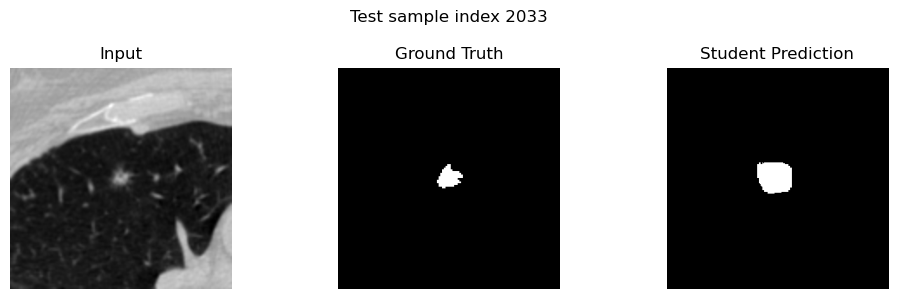

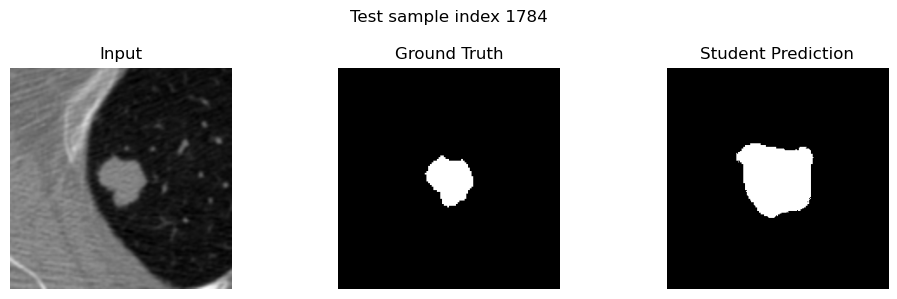

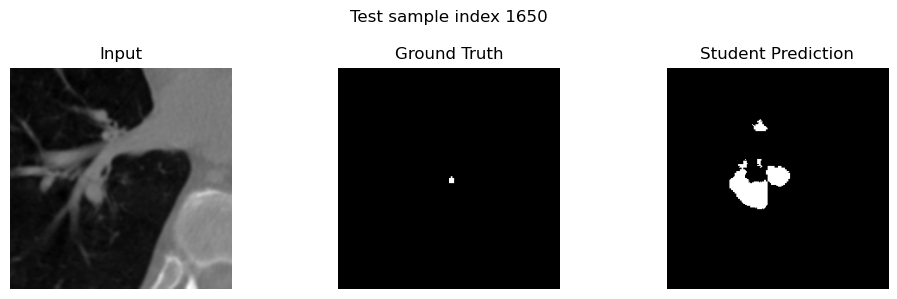

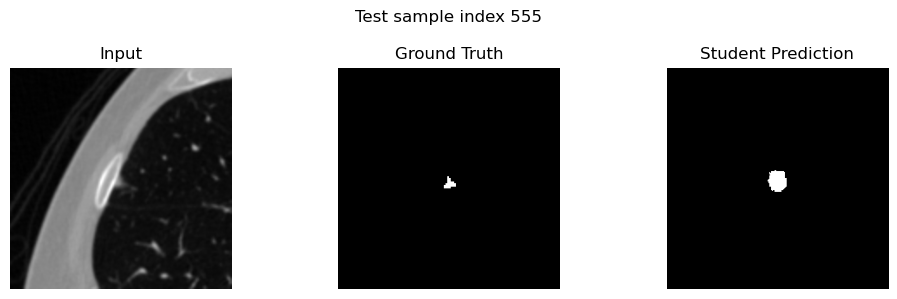

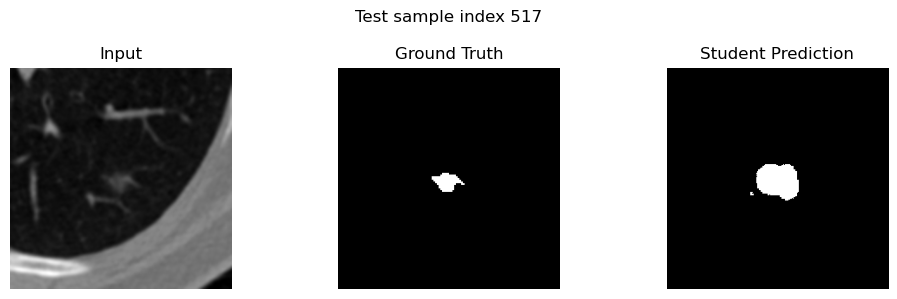

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ----------------------------
# Load fixed test indices
# ----------------------------
fixed_indices = np.load(
    "/home/g202417400/Msproject/MSPO-Net/semisup_runs_dw/qualitative_samples/fixed_test_indices.npy"
)

print("Using fixed test indices:", fixed_indices)

dataset = dl_test.dataset
student.eval()

# ----------------------------
# Helper: predict student mask
# ----------------------------
def predict_student(model, img, threshold=0.5):
    with torch.no_grad():
        x = img.unsqueeze(0).to(DEVICE)   # [1,1,H,W]
        logits = model(x)
        probs = torch.sigmoid(logits)[0, 0]
    return (probs >= threshold).cpu().numpy()

# ----------------------------
# Visualization loop
# ----------------------------
for idx in fixed_indices:
    idx = int(idx)

    img, gt = dataset[idx]        # img, gt: [1,H,W]
    pred = predict_student(student, img)

    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(img.squeeze().numpy(), cmap="gray")
    plt.title("Input")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt.squeeze().numpy(), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap="gray")
    plt.title("Student Prediction")
    plt.axis("off")

    plt.suptitle(f"Test sample index {idx}")
    plt.tight_layout()
    plt.show()


In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pathlib import Path

# --------------------------------------------------
# Paths
# --------------------------------------------------
SAMPLES_DIR = Path("/home/g202417400/Msproject/MSPO-Net/semisup_runs_dw/qualitative_samples")
pdf_path = SAMPLES_DIR / "Attunet.pdf"

# --------------------------------------------------
# Load fixed test indices
# --------------------------------------------------
fixed_indices = np.load(SAMPLES_DIR / "fixed_test_indices.npy")
print("Using fixed test indices:", fixed_indices)

dataset = dl_test.dataset
student.eval()

# --------------------------------------------------
# Helper: student prediction
# --------------------------------------------------
def predict_student(model, img, threshold=0.5):
    with torch.no_grad():
        x = img.unsqueeze(0).to(DEVICE)   # [1,1,H,W]
        logits = model(x)
        probs = torch.sigmoid(logits)[0, 0]
    return (probs >= threshold).cpu().numpy()

# --------------------------------------------------
# Save all samples into ONE PDF
# --------------------------------------------------
with PdfPages(pdf_path) as pdf:
    for idx in fixed_indices:
        idx = int(idx)

        img, gt = dataset[idx]        # [1,H,W]
        pred = predict_student(student, img)

        fig = plt.figure(figsize=(10, 3))

        plt.subplot(1, 3, 1)
        plt.imshow(img.squeeze().numpy(), cmap="gray")
        plt.title("Input")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt.squeeze().numpy(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap="gray")
        plt.title("Student Prediction")
        plt.axis("off")

        plt.suptitle(f"SwinUNet – Test sample index {idx}")
        plt.tight_layout()

        pdf.savefig(fig, bbox_inches="tight")
        plt.close(fig)

print(f"Saved qualitative results to: {pdf_path}")


Using fixed test indices: [2033 1784 1650  555  517]
Saved qualitative results to: /home/g202417400/Msproject/MSPO-Net/semisup_runs_dw/qualitative_samples/Attunet.pdf


SWINUNET

In [40]:
from Weakly.metrics_profile import (
    evaluate_binary_segmentation,
    estimate_gflops,
    benchmark_inference
)

teacher_metrics = evaluate_binary_segmentation(
    teacher,
    dl_test,          # fine/consensus GT loader
    DEVICE,
    threshold=0.5
)

print("\n=== Teacher Test Metrics ===")

order = ["acc", "precision", "recall", "f1", "iou", "dice", "specificity",
         "hd95_mean", "hd95_std", "hd95_n"]

for k in order:
    v = teacher_metrics.get(k, None)

    if v is None:
        print(f"{k}: N/A")
    elif k == "hd95_n":
        print(f"{k}: {int(v)}")
    else:
        print(f"{k}: {float(v):.4f}")



=== Teacher Test Metrics ===
acc: 0.9835
precision: 0.3310
recall: 0.9854
f1: 0.4955
iou: 0.3293
dice: 0.4955
specificity: 0.9834
hd95_mean: 13.3554
hd95_std: 9.7923
hd95_n: 3095


In [46]:
ms_img, fps = benchmark_inference(
    teacher,
    input_shape=(1, 1, 256, 256),
    device=str(DEVICE)   # <-- THIS fixes it
)


In [49]:
from Weakly.metrics_profile import benchmark_inference

teacher.eval()
ms_img, fps = benchmark_inference(
    teacher,
    input_shape=(1, 1, 256, 256),
    device=str(DEVICE)   # <-- THIS fixes it
)


print(f"Teacher inference: {ms_img:.2f} ms/image | {fps:.1f} FPS")


ms_img, fps = benchmark_inference(
    student,
    input_shape=(1, 1, 256, 256),
    device=str(DEVICE)
)

print(f"student inference: {ms_img:.2f} ms/image | {fps:.1f} FPS")




Teacher inference: 8.06 ms/image | 124.1 FPS
student inference: 2.95 ms/image | 339.2 FPS


In [42]:
gflops, params_m = estimate_gflops(teacher, device=DEVICE)
#ms_img, fps = benchmark_inference(teacher, device=DEVICE)

print(f"\nGFLOPs: {gflops if gflops is not None else 'N/A'}")
print(f"Params (M): {params_m:.2f}")
#print(f"Inference: {ms_img:.2f} ms/image | {fps:.1f} FPS")

student.eval()
student_metrics = evaluate_binary_segmentation(
    student,
    dl_test,
    DEVICE,
    threshold=0.5
)

print("\n=== Student Test Metrics ===")

order = ["acc", "precision", "recall", "f1", "iou", "dice", "specificity",
         "hd95_mean", "hd95_std", "hd95_n"]

for k in order:
    v = student_metrics.get(k, None)

    if v is None:
        print(f"{k}: N/A")
    elif k == "hd95_n":
        print(f"{k}: {int(v)}")
    else:
        print(f"{k}: {float(v):.4f}")

gflops, params_m = estimate_gflops(student, device=DEVICE)
#ms_img, fps = benchmark_inference(student, device=DEVICE)

print(f"\nGFLOPs: {gflops if gflops is not None else 'N/A'}")
print(f"Params (M): {params_m:.2f}")
#print(f"Inference: {ms_img:.2f} ms/image | {fps:.1f} FPS")



GFLOPs: 24.059044272
Params (M): 45.15

=== Student Test Metrics ===
acc: 0.9826
precision: 0.3077
recall: 0.8883
f1: 0.4571
iou: 0.2963
dice: 0.4571
specificity: 0.9834
hd95_mean: 33.1460
hd95_std: 24.7301
hd95_n: 2981

GFLOPs: 7.103709184
Params (M): 1.49


In [54]:
from Weakly.metrics_profile import (
    evaluate_binary_segmentation,
    estimate_gflops,
    benchmark_inference
)


teacher.eval()
teacher_metrics = evaluate_binary_segmentation(
    teacher,
    dl_test,          # <-- fine/consensus GT loader
    DEVICE,
    threshold=0.5
)

print("\n=== Teacher Test Metrics ===")
for k, v in teacher_metrics.items():
    print(f"{k}: {v:.4f}")

    



=== Teacher Test Metrics ===
acc: 0.9843
precision: 0.3387
recall: 0.9485
f1: 0.4991
iou: 0.3326
dice: 0.4991
specificity: 0.9846


In [55]:
student.eval()
student_metrics = evaluate_binary_segmentation(
    student,
    dl_test,
    DEVICE,
    threshold=0.5
)

print("\n=== Student Test Metrics ===")
for k, v in student_metrics.items():
    print(f"{k}: {v:.4f}")



=== Student Test Metrics ===
acc: 0.9842
precision: 0.3286
recall: 0.8811
f1: 0.4786
iou: 0.3146
dice: 0.4786
specificity: 0.9850


In [56]:
gflops_t, params_t = estimate_gflops(teacher, input_shape=(1,1,256,256), device=DEVICE)
gflops_s, params_s = estimate_gflops(student, input_shape=(1,1,256,256), device=DEVICE)

print("\n=== Model Complexity ===")
print(f"Teacher: {gflops_t:.2f} GFLOPs, {params_t:.2f} M params")
print(f"Student: {gflops_s:.2f} GFLOPs, {params_s:.2f} M params")



=== Model Complexity ===
Teacher: 59.77 GFLOPs, 8.36 M params
Student: 7.10 GFLOPs, 1.49 M params


In [58]:
import numpy as np
from pathlib import Path

SAMPLES_DIR = OUT_DIR / "qualitative_samples"
SAMPLES_DIR.mkdir(parents=True, exist_ok=True)

np.random.seed(SEED)

num_test = len(dl_test.dataset)
fixed_indices = np.random.choice(num_test, size=5, replace=False)

np.save(SAMPLES_DIR / "fixed_test_indices.npy", fixed_indices)

print("Saved fixed test indices:", fixed_indices)


Saved fixed test indices: [2033 1784 1650  555  517]


In [59]:
fixed_indices = np.load(SAMPLES_DIR / "fixed_test_indices.npy")
print("Using fixed test indices:", fixed_indices)


Using fixed test indices: [2033 1784 1650  555  517]


Using fixed test indices: [2033 1784 1650  555  517]


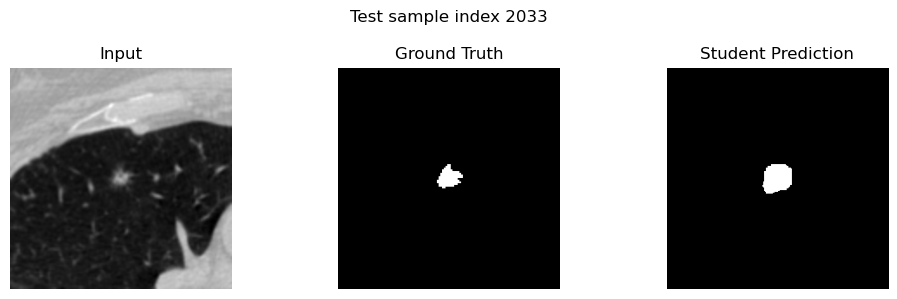

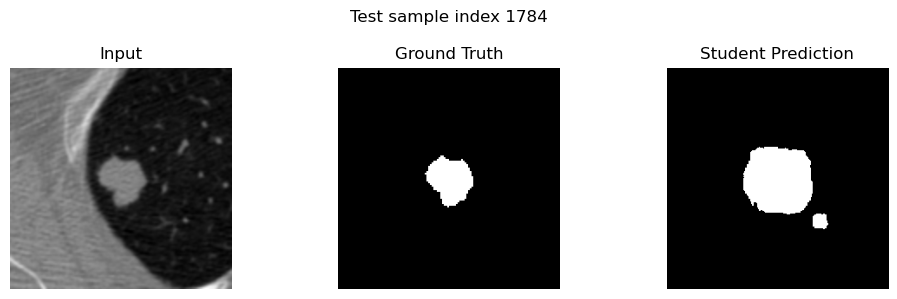

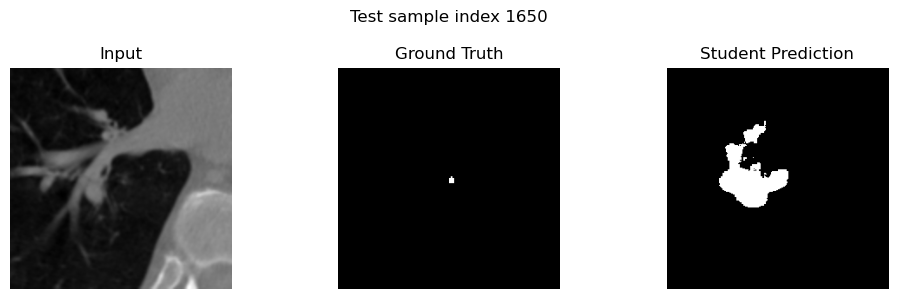

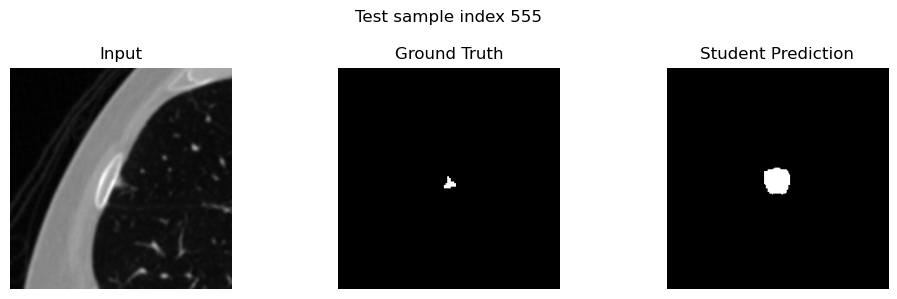

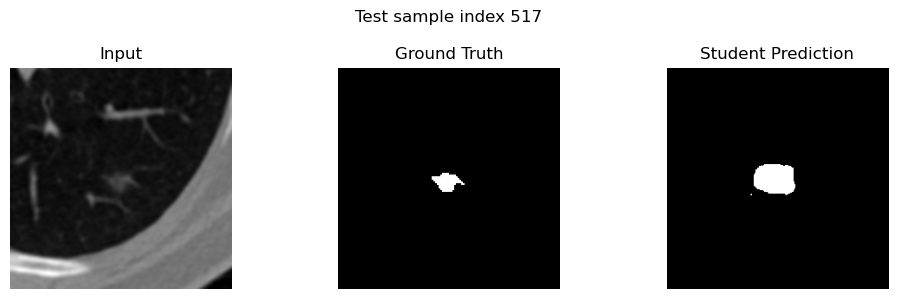

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ----------------------------
# Load fixed test indices
# ----------------------------
fixed_indices = np.load(
    "/home/g202417400/Msproject/MSPO-Net/semisup_runs_dw/qualitative_samples/fixed_test_indices.npy"
)

print("Using fixed test indices:", fixed_indices)

dataset = dl_test.dataset
student.eval()

# ----------------------------
# Helper: predict student mask
# ----------------------------
def predict_student(model, img, threshold=0.5):
    with torch.no_grad():
        x = img.unsqueeze(0).to(DEVICE)   # [1,1,H,W]
        logits = model(x)
        probs = torch.sigmoid(logits)[0, 0]
    return (probs >= threshold).cpu().numpy()

# ----------------------------
# Visualization loop
# ----------------------------
for idx in fixed_indices:
    idx = int(idx)

    img, gt = dataset[idx]        # img, gt: [1,H,W]
    pred = predict_student(student, img)

    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(img.squeeze().numpy(), cmap="gray")
    plt.title("Input")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt.squeeze().numpy(), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap="gray")
    plt.title("Student Prediction")
    plt.axis("off")

    plt.suptitle(f"Test sample index {idx}")
    plt.tight_layout()
    plt.show()


In [51]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pathlib import Path

# --------------------------------------------------
# Paths
# --------------------------------------------------
SAMPLES_DIR = Path("/home/g202417400/Msproject/MSPO-Net/semisup_runs_dw/qualitative_samples")
pdf_path = SAMPLES_DIR / "swinunet.pdf"

# --------------------------------------------------
# Load fixed test indices
# --------------------------------------------------
fixed_indices = np.load(SAMPLES_DIR / "fixed_test_indices.npy")
print("Using fixed test indices:", fixed_indices)

dataset = dl_test.dataset
student.eval()

# --------------------------------------------------
# Helper: student prediction
# --------------------------------------------------
def predict_student(model, img, threshold=0.5):
    with torch.no_grad():
        x = img.unsqueeze(0).to(DEVICE)   # [1,1,H,W]
        logits = model(x)
        probs = torch.sigmoid(logits)[0, 0]
    return (probs >= threshold).cpu().numpy()

# --------------------------------------------------
# Save all samples into ONE PDF
# --------------------------------------------------
with PdfPages(pdf_path) as pdf:
    for idx in fixed_indices:
        idx = int(idx)

        img, gt = dataset[idx]        # [1,H,W]
        pred = predict_student(student, img)

        fig = plt.figure(figsize=(10, 3))

        plt.subplot(1, 3, 1)
        plt.imshow(img.squeeze().numpy(), cmap="gray")
        plt.title("Input")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt.squeeze().numpy(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap="gray")
        plt.title("Student Prediction")
        plt.axis("off")

        plt.suptitle(f"SwinUNet – Test sample index {idx}")
        plt.tight_layout()

        pdf.savefig(fig, bbox_inches="tight")
        plt.close(fig)

print(f"Saved qualitative results to: {pdf_path}")


Using fixed test indices: [2033 1784 1650  555  517]
Saved qualitative results to: /home/g202417400/Msproject/MSPO-Net/semisup_runs_dw/qualitative_samples/swinunet.pdf


In [60]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def predict_binary_mask(model, x, device, threshold=0.5):
    model.eval()
    x = x.to(device)
    logits = model(x)
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).float()
    return preds.cpu()


In [61]:
def save_student_predictions(
    student,
    test_dataset,
    device,
    indices,
    out_dir,
    threshold=0.5
):
    out_dir.mkdir(parents=True, exist_ok=True)
    student.eval()

    for idx in indices:
        img, gt = test_dataset[idx]

        # add batch dim
        img_b = img.unsqueeze(0)
        pred = predict_binary_mask(student, img_b, device, threshold)

        img_np = img.permute(1, 2, 0).cpu().numpy()
        gt_np = gt.squeeze().cpu().numpy()
        pred_np = pred.squeeze().numpy()

        fig, ax = plt.subplots(1, 3, figsize=(12, 4))

        ax[0].imshow(img_np)
        ax[0].set_title("Original Image")
        ax[0].axis("off")

        ax[1].imshow(gt_np, cmap="gray")
        ax[1].set_title("GT Mask")
        ax[1].axis("off")

        ax[2].imshow(pred_np, cmap="gray")
        ax[2].set_title("Student Prediction")
        ax[2].axis("off")

        plt.tight_layout()

        save_path = out_dir / f"sample_{idx:04d}.png"
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        plt.close()

        print(f"Saved: {save_path}")


In [62]:
save_student_predictions(
    student=student,
    test_dataset=dl_test.dataset,
    device=DEVICE,
    indices=fixed_indices,
    out_dir=SAMPLES_DIR,
    threshold=0.5
)


Saved: /home/g202417400/Msproject/MSPO-Net/semisup_runs_dw/qualitative_samples/sample_2033.png
Saved: /home/g202417400/Msproject/MSPO-Net/semisup_runs_dw/qualitative_samples/sample_1784.png
Saved: /home/g202417400/Msproject/MSPO-Net/semisup_runs_dw/qualitative_samples/sample_1650.png
Saved: /home/g202417400/Msproject/MSPO-Net/semisup_runs_dw/qualitative_samples/sample_0555.png
Saved: /home/g202417400/Msproject/MSPO-Net/semisup_runs_dw/qualitative_samples/sample_0517.png
